In [ ]:
### 1. 머신러닝 (50점)
# 문제 : https://www.datamanim.com/dataset/ADPpb/00/25.html
# 풀이 : https://stherhj.tistory.com/191

In [ ]:
# # 1번 데이터 확인 및 전처리
# 1.1 F(소비자별 구매빈도), M(소비자별 총 구매액) feature를 새로 생성해서 그 결과값으로 탐색적 분석 실시
# 1.2 F, M feature 기반으로 군집분석 실시, 필요시 이상값 보정
# 1.3 군집 결과의 적합성을 군집 내 응집도, 군집 간 분리도의 개념을 사용해서 서술
# 1.4 적합된 군집 별 특성에 대한 의견과 비즈니스적 판단 제시

## 데이터 설명
# InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter ‘c’, it indicates a cancellation.
# StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
# Description: Product (item) name. Nominal.
# Quantity: The quantities of each product (item) per transaction. Numeric.
# InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
# UnitPrice: Unit price. Numeric, Product price per unit in sterling.
# CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
# Country: Country name. Nominal, the name of the country where each customer resides.

In [1]:
# 1.1 F(소비자별 구매빈도), M(소비자별 총 구매액) feature를 새로 생성해서 그 결과값으로 탐색적 분석 실시
import numpy as np
import pandas as pd
from scipy.stats import norm,sem

df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/25/problem1.csv')
df['amount'] = df['Quantity']*df['UnitPrice']
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
41019,560590,21884,CAKES AND BOWS GIFT TAPE,12,7/19/2011 15:55,0.65,12560.0,Germany,7.80
41020,561870,21156,RETROSPOT CHILDRENS APRON,8,7/31/2011 11:45,1.95,14911.0,EIRE,15.60
41021,579792,22436,12 COLOURED PARTY BALLOONS,20,11/30/2011 15:43,0.65,12714.0,France,13.00
41022,C566753,22796,PHOTO FRAME 3 CLASSIC HANGING,-1,9/14/2011 15:48,9.95,14911.0,EIRE,-9.95
41023,546875,22383,LUNCH BAG SUKI DESIGN,10,3/17/2011 16:38,1.65,12514.0,Italy,16.50


In [2]:
df_cnt = df.groupby('CustomerID').count()[['InvoiceNo']]
df_amounts = df.groupby('CustomerID').sum()[['amount']]
df02 = pd.concat([df_cnt, df_amounts], axis = 1)

df02.describe()
# M(소비자별 총 구매액) 이 마이너스인 경우 존재
df02[df02['InvoiceNo'] == 5903]
# 14911 고객은 5903회 구매함
df02[df02['amount'] == 279489.02]
# 14646 고객은 279489.02원 구매함

,InvoiceNo,amount
CustomerID,,
14646.0,2085,279489.02


In [3]:
# 1.2 F, M feature 기반으로 군집분석 실시, 필요시 이상값 보정
# M(소비자별 총 구매액) 이 마이너스인 경구 KNN대체로 이상값 보정
df02_nan = df02[df02['amount'] <= 0] 
df02.loc[df02_nan.index, 'amount'] = np.NaN # 이상피 na로변경

In [4]:
fill_columns = ['amount']
from sklearn.impute import KNNImputer
imputer = KNNImputer()
df02_knnim = imputer.fit_transform(df02[fill_columns])
df02[fill_columns] = df02_knnim

In [5]:
# F, M feature 기반으로 군집분석 실시
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score

for k in range(2, 10):
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(df02)
    labels = kmeans_model.labels_
    print(calinski_harabasz_score(df02, labels))

1633.050633906334
6506.8030880599845
11567.253198132285
17330.540133574283
19558.228821009623
24842.08652895179
28093.71854521894
35177.88312211013


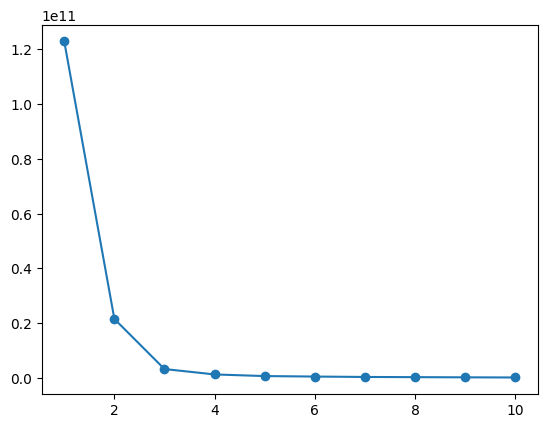

[122905421241.43834, 21487714877.511475, 3174161268.7179356, 1206407434.0627067, 605131161.149899, 428601493.1010959, 280807863.36041266, 212125871.08202493, 145347766.03129727, 91993225.70873888]


In [6]:
import matplotlib.pyplot as plt
def elbow(X):
    sse = []
    for i in range(1,11):
        km = KMeans(n_clusters=i, random_state=2023)
        km.fit(df02)
        sse.append(km.inertia_)
    
    plt.plot(range(1, 11), sse, marker = 'o')
    plt.show()
    print(sse)

elbow(df02)
# 기울기가 급격히 감소하는 k=3 으로 지정

In [7]:
# 최적의 k로 k-means 군집화 실행
km = KMeans(n_clusters = 3, random_state=2023) # 3의로 하면 실루엇계수가 0인 군집 존재
km.fit(df02)

KMeans(n_clusters=3, random_state=2023)

In [8]:
# 할당된 군집 데이터 추가
new_lables = km.labels_
df02['cluster'] = new_lables

In [9]:
df02.groupby(['cluster']).mean()

,InvoiceNo,amount
cluster,,
0,89.645349,2157.835148
1,2085.000000,279489.020000
2,2700.333333,123227.403333


In [127]:
## 1.3 군집 결과의 적합성을 군집 내 응집도, 군집 간 분리도의 개념을 사용해서 서술
## - 실루엣 분석(silhouette analysis)
# 실루엣 계수가 데이터별로 그 데이터가 속한 군내의(거리기반) 유사도와 인접한 군의 유사도를 비교하는 지표
# 군집 품질을 평가하는 또 다른 방법
# 클러스터 내 데이터들이 얼마나 조밀하게 모여있는지를 측정하는 그래프 도구
## 계수 구하는 방법
# 하나의 임의의 데이터(x(i))와 동일한 클러스터 내의 모든 다른 데이터 포인트 사이의 거리를 평균하여 클러스터의 응집력(a(i))을 계산
# 앞서 선정한 데이터와 가장 가까운 클러스터의 모든 샘플간 평균 거리로 최근접 클러스터의 클러스터 분리도(b(i))를 계산
# 클러스터 응집력과 분리도 사이의 차이를 둘 중 큰 값으로 나눠 실루엣 계수(s(i))를 계산
# 분리도 = 응집력 : 실루엣 계수는 0이 됨, 클러스터가 중첩되어 있다는 의미
# 분리도 > 응집력 : 이상적인 실루엣 계수인 1에 가깝게 됨
# 분리도 : 데이터가 다른 클러스터와 얼마나 다른지를 나타냄
# 응집력 : 클러스터 내 다른 샘플과 얼마나 비슷한지를 나타냄, 작을수록 클러스터 내 다른 데이터들과 비슷함

In [10]:
from sklearn.metrics import silhouette_samples, silhouette_score
X = df02.drop(['cluster'], axis=1)
y = df02['cluster']
silhouette_vals = silhouette_samples(X, y, metric = 'euclidean')
df02['sil'] = silhouette_vals

In [11]:
ave_score = silhouette_score(X, y)
ave_score

0.9748462607654366

In [12]:
df02.groupby(['cluster']).mean()

,InvoiceNo,amount,sil
cluster,,,
0,89.645349,2157.835148,0.978433
1,2085.000000,279489.020000,0.000000
2,2700.333333,123227.403333,0.888517


In [13]:
df02.groupby(['cluster']).count()

,InvoiceNo,amount,sil
cluster,,,
0,344,344,344
1,1,1,1
2,3,3,3


In [14]:
# 군집 결과의 적합성을 군집 내 응집도, 군집 간 분리도를 기반으로 군집분석이 잘 되었는지 실루엇 계수를 활용하여 판별해보았다.
# (실루엣 계수는 데이터별로 그 데이터가 속한 군내의(거리기반) 유사도와 인접한 군의 유사도를 비교하는 지표)
# 전체 실루엣 계수는 0.97로 매우 군집 내 응집도가 높고 군집 간 분리도가 높을것으로 보임
# cluster0, cluster2는 각각 0.98, 0.89로 매우 군집 내 응집도가 높고 군집 간 분리도가 높을것으로 보이나 cluster1의 실루엇 계수가 0으로 잘 분리되지 않음.

In [15]:
# 1.4 적합된 군집 별 특성에 대한 의견과 비즈니스적 판단 제시
# 군집분석결과 전체 데이터의 대부분이 한 cluster로 분류되어 대부분 유사한 성격을 보임
# 해당 분석 결과를 기반으로 고객의 군집을 분류하기는 어려움

# 고객의 성향에 따라서 구매하는 Item에 차이가 있으므로 
# StockCode와 Description을 기반으로 아이템에 대한 성격을 구분하고 이를 기반으로 군집분석 아이템별 F(소비자별 구매빈도), M(소비자별 총 구매액)으로 군집분석을 시도해보면 좋을것 같습니다.

In [ ]:
## 2.시계열분석
# 2.1 EDA와 시각화를 진행하라
# 2.2 결측치 처리와 해당 결측치 처리 방식에 대한 논리적 근거를 제시하라
# 2.3 계절성을 반영한 시계열 모델을 제시하고 정확도 측면에서 모델 성능 평가 할 것
# 2.4 분석 결과 활용 가능 여부에 대한 분석 전문가로서의 제안

In [16]:
import pandas as pd

df11 = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/25/problem2.csv' ,index_col = 0)
df11.tail()

,counts
295,445.2
296,472.0
297,341.6
298,477.8
299,588.8


In [17]:
df11.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 299
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   counts  295 non-null    float64
dtypes: float64(1)
memory usage: 4.7 KB


In [18]:
df11.isna().sum() # 결측 5개 존재

counts    5
dtype: int64

In [19]:
df11.describe()

,counts
count,295.000000
mean,498.678305
std,97.603920
min,239.400000
25%,432.600000
50%,499.800000
75%,565.550000
max,729.200000


(array([ 3., 11., 26., 37., 54., 60., 48., 27., 19., 10.]),
 array([239.4 , 288.38, 337.36, 386.34, 435.32, 484.3 , 533.28, 582.26,
        631.24, 680.22, 729.2 ]),
 <BarContainer object of 10 artists>)

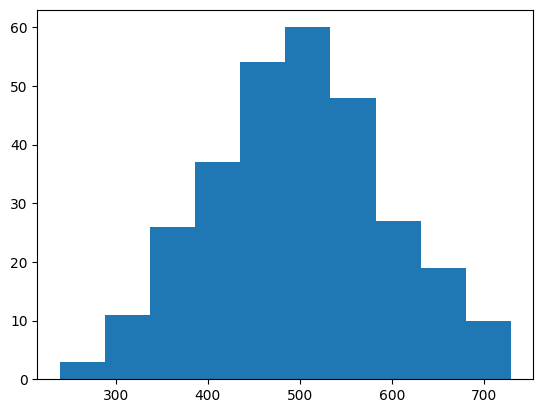

In [20]:
import matplotlib.pyplot as plt
plt.hist('counts', data = df11)

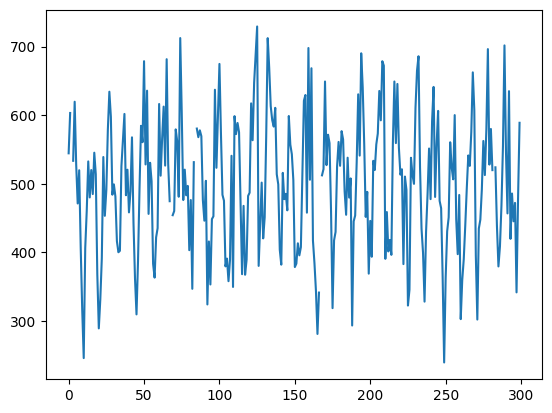

In [21]:
# 시계열 시각화
plt.plot(df11.index, df11['counts'])
# 지속적으로 상승과 하락이 반복되어 계절성이 존재할것으로 보임

In [22]:
# 2.2 결측치 처리와 해당 결측치 처리 방식에 대한 논리적 근거를 제시하라
df11[df11['counts'].isna() == True]
# 결측치 처리를 위해서는 삭제, 평균 대체 등의 다양한 방식이 존재하지만,
# 시간의 흐름이 존재하는 시계열 데이터의 특성을 반영하여 결측일 이전일과 이후일에 평균으로 대체하여 시계열의 추세가 반영될 수 있도록 결측치 처리한다.

,counts
2,NaN
68,NaN
84,NaN
167,NaN
282,NaN


In [23]:
df11[281:285]

,counts
281,519.8
282,NaN
283,523.9
284,438.5


In [24]:
# df11['counts'][2] = (603.1 + 533.4)/2
# df11['counts'][68] = (474.5 + 454.1)/2
# df11['counts'][84] = (531.4 + 580.4)/2
# df11['counts'][167] = (341.3 + 512.2)/2
df11['counts'][282] = (519.8 + 523.9)/2

In [25]:
## 2.3 계절성을 반영한 시계열 모델을 제시하고 정확도 측면에서 모델 성능 평가 할 것
# train, test 분리
df11_train = df11[:197]
df11_test = df11[197:]

In [26]:
# sarima 모델 학습
from pmdarima import auto_arima

auto_model = auto_arima(df11_train, start_p=0, d=1, start_q=0,
                        max_p=3, max_q=3, 
                        start_P=0, start_Q=0,
                        max_P=3, max_Q=3, m=12,
                        seasonal=True, information_criterion='aic',
                        trace=True)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [27]:
# 2.3 계절성을 반영한 시계열 모델을 제시하고 정확도 측면에서 모델 성능 평가 할 것
auto_model.summary()

# 최종 선택한 모델은 SARIMAX(3, 1, 0)x(2, 0, [1], 12) 모델로 AIC 2266으로 가장낮은 모델을 선택함

NameError: name 'auto_model' is not defined

In [241]:
# 학습 데이터셋으로부터 test 데이터 길이만큼 예측
auto_pred_y= pd.DataFrame(auto_model.predict(n_periods=len(df11_test)), 
                          index=df11_test.index) 
auto_pred_y.columns = ['predicted_price']
auto_pred_y


,predicted_price
197,611.222960
198,498.538105
199,454.120646
200,440.283965
201,427.912083
...,...
295,509.675321
296,473.651973
297,481.521440
298,512.323582


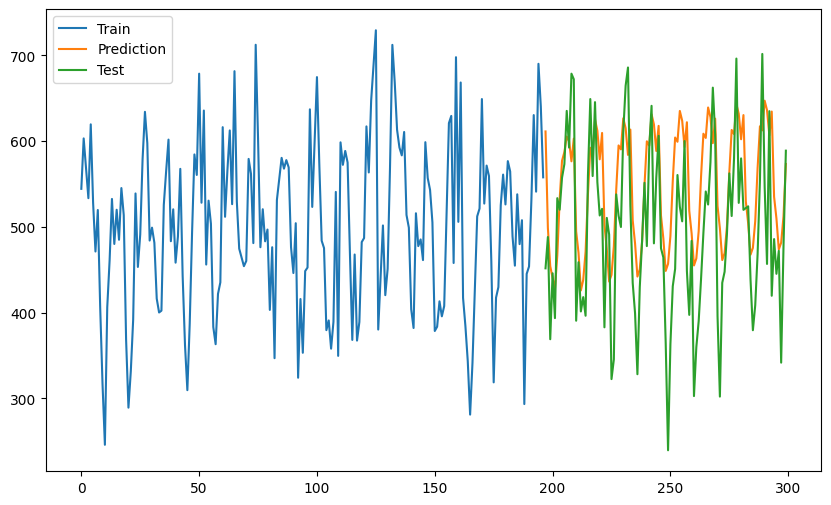

In [242]:
plt.figure(figsize=(10,6))
plt.plot(df11_train, label="Train") # Train 데이터 
plt.plot(auto_pred_y, label="Prediction") # 모델이 예상한 그래프 
plt.plot(df11_test, label="Test") # 실제 가격 그래프 
plt.legend(loc='upper left')
plt.show()


In [243]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("r2_score : ", r2_score(df11_test, auto_pred_y))
RMSE = mean_squared_error(df11_test, auto_pred_y)**0.5
print("RMSE : " , RMSE)

r2_score :  0.21208957183725197
RMSE :  86.63643972884736


In [ ]:
# 2.4 분석 결과 활용 가능 여부에 대한 분석 전문가로서의 제안
# SARIMA 모델은 21%의 정확도를 가지고 예측하며 평균오차는 86으로 매우 낮은 정확도를 보임
# 현재의 상태로는 분석 결과 활용이 어려우며 좀더 장기간의 데이터를 확보하거나 잔차를 제거할 수 있는 방안에 대한 모색이 필요함